In [3]:
using DifferentialEquations
using Plots
using DataFrames
using Random
using CSV
using Polyhedra #For creating convex hulls
using QHull #For creating convex hulls
using CSV
using DataFrames

In [14]:
michaelis_menten(x, kcat, km) = (kcat*x)/(km+x)
sigma1(s, theta, h) = s^h/(theta^h + s^h)
sigma2(s, theta, h) = theta^h/(theta^h + s^h)
#Define ODE model and solve
"""ode(du, u, t)
        Defines a system of differential equations for a 3D bistable switch
""" 
function ode(du, u, p, t)
    mu1, mu2 = p
    gamma = 2E-4
    kcat1 = 32
    kcat2 = 320
    km = 4.7
    so = 4.7
    eoff = 0.0025 #uM 
    e1on = mu1*eoff
    e2on = mu2*eoff
    ko = eoff*gamma
    k11 = e1on*gamma - ko
    k12 = e2on*gamma - ko
    du[1] = michaelis_menten(so, kcat1, km)*u[2] - michaelis_menten(u[1], kcat2, km)*u[3] #s
    du[2] = ko + k11*sigma1(u[1], so, 2) - gamma*u[2] #e1
    du[3] = ko + k12*sigma2(u[1], so, 2) - gamma*u[3] #e2
end


"""solve_ode(u0)
        Integrates ODE system and returns the solution.
""" 
function solve_ode(u0, p, endtime=1E5, resolution=200)
    tspan = [0, endtime] #Span of time to integrate for
    savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
    prob = ODEProblem(ode, u0, tspan, p)
    sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    return sol
end 

solve_ode

In [15]:
#Confirm ODE results using grid search - 19, 2
data = DataFrame()
for x in LinRange(0., 100., 10)
    for y in LinRange(0., 0.06, 10)
        for z in LinRange(0., 0.006, 10)
            ss = solve_ode([x, y, z], [19, 2], 1E6).u[end]
            data = vcat(data, DataFrame("x" => [x], "y" => [y], "z" => [z], "ss_x" => [ss[1]], "ss_y" => [ss[2]], "ss_z" => [ss[3]], "score" => [ss[1]+ss[2]+ss[3]]))
        end
    end
end
data[!, "class"] = [string(round(abs(data.score[i]), digits=1)) for i in 1:nrow(data)]
CSV.write("grid_search_19_2.csv", data)

#Confirm ODE results using grid search - 10, 10
data = DataFrame()
for x in LinRange(0., 5., 10)
    for y in LinRange(0., 0.03, 10)
        for z in LinRange(0., 0.03, 10)
            ss = solve_ode([x, y, z], [10, 10], 1E6).u[end]
            data = vcat(data, DataFrame("x" => [x], "y" => [y], "z" => [z], "ss_x" => [ss[1]], "ss_y" => [ss[2]], "ss_z" => [ss[3]], "score" => [ss[1]+ss[2]+ss[3]]))
        end
    end
end
data[!, "class"] = [string(round(abs(data.score[i]), digits=1)) for i in 1:nrow(data)]
CSV.write("grid_search_10_10.csv", data)


#Construct hulls?
# hull = chull([data.x data.y data.z])
# Create a 3D scatter plot
# scatter3d(data.x, data.y, data.z, zcolor=data.score, xlabel="X", ylabel="Y", zlabel="Z", legend=false, color=:blues)
# scatter3d(data.y, data.z, data.x, zcolor=data.score, xlabel="X", ylabel="Y", zlabel="Z", legend=false, color=:blues)

"grid_search_10_10.csv"

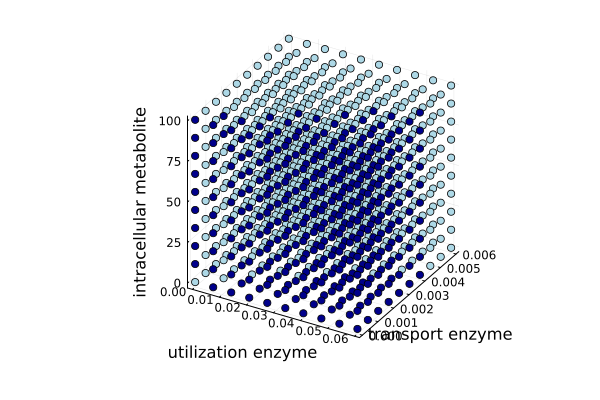

In [19]:
#Plot 3D results and confirm 
data_10_10 = CSV.read("grid_search_10_10.csv", DataFrame)
data_19_2 = CSV.read("grid_search_19_2.csv", DataFrame)
data = data_19_2

scatter3d(data.y, data.z, data.x, zcolor=data.score, 
          xlabel="utilization enzyme", 
          ylabel="transport enzyme", 
          zlabel="intracellular metabolite", 
          legend=false, color=:blues)


In [78]:
###RUN STEADY STATE SEARCH IN 3D
#Sample parameter space
"""initial_sampling(lower_bounds, upper_bounds, n_init)
        Returns n_init samples between lower_bounds and upper_bounds. 
""" 
function initial_sampling(lower_bounds, upper_bounds, n_init)
    #Sample uniform points across space
    n_dims = length(lower_bounds)
    samples = Matrix{Float64}(undef, n_init, n_dims)
    for d in 1:n_dims
        lb = lower_bounds[d]
        ub = upper_bounds[d]
        for i in 1:n_init
            samples[i, d] = rand() * (ub - lb) + lb
        end
    end

    return samples
end

#Solve ODE and score
"""compute_classes(samples::Matrix(NxD))
        Given a set of initial conditions (samples), computes the steady state and converts to a string identifier for the class
"""
function compute_classes(samples, steady_states)
    classes = []
    for i in 1:size(samples, 1)
        ss = solve_ode(samples[i, :], [19, 2], 1E6).u[end]
        found = false
        for s in steady_states
            if isapprox(ss, s, atol=0.01)
                push!(classes, class_name(s))
                found = true
                break
            end
        end
        if !found
            push!(steady_states, ss)
            push!(classes, class_name(ss))
        end
    end
    return classes, collect(steady_states)
end


function class_name(ss)
    return string(round(abs(ss[1]), digits=1))*", "*string(round(abs(ss[2]), digits=1))
end

function create_convex_hull(points)
    #Instantiates list of convex hulls based on a set of points 
    #Returns hull and convex hull metric
    hull = chull(mapreduce(permutedims, vcat, points))
    return hull, hull.volume
end

function create_hulls_and_compute_volume(classes, samples)
    hulls = []
    total_volume = 0
    for c in unique(classes)
        class_indices = findall(x -> x == c, classes)
        hull_points = samples[class_indices, :]
        hull_points = [row[:] for row in eachrow(hull_points)]
        if length(class_indices) >= 4
            hull, vol = create_convex_hull(hull_points)
            total_volume = vol + total_volume
            push!(hulls, hull)
        end
    end
    return hulls, total_volume
end

#Remove each point and inflate convex hulls to score
function one_out_scoring(samples, classes)
    scores = []
    temp_hulls = []
    for i in 1:size(samples)[1]
        rem_samples = vcat(samples[1:i-1, :], samples[i+1:end, :])
        rem_classes = vcat(classes[1:i-1], classes[i+1:end])
        total_volume = 0
        for ss in unique(classes)
            class_indices = findall(x -> x == ss, rem_classes)
            hull_points = rem_samples[class_indices, :]
            hull_points = [row[:] for row in eachrow(hull_points)]
            if length(class_indices) >= 3
                hull, vol = create_convex_hull(hull_points)
                push!(temp_hulls, hull)
                total_volume = vol + total_volume
            end
        end
        push!(scores, total_volume)
    end
    return scores
end

#Determine next sample balancing exploration/exploitation
function sampling(n_rand, lower_bounds, upper_bounds)
    # Initialize an array to hold the random samples
    samples = zeros(n_rand, 3)
    
    # For each dimension, scale and shift the random numbers
    for dim in 1:3
        # Generate uniform random numbers for this dimension
        rand_vals = rand(n_rand)
        
        # Scale and shift according to the bounds
        scale = upper_bounds[dim] - lower_bounds[dim]
        samples[:, dim] = lower_bounds[dim] .+ scale * rand_vals
    end
    return samples
end

function computeGeometricCenter(verts)
    n = length(verts)
    if n == 0
        error("The list of vertices is empty.")
    end

    # Initialize sum vectors
    sumX = 0.0
    sumY = 0.0
    sumZ = 0.0

    for vert in verts
        sumX += vert[1]
        sumY += vert[2]
        sumZ += vert[3]
    end

    # Compute the average for each coordinate
    centerX = sumX / n
    centerY = sumY / n
    centerZ = sumZ / n

    return [centerX, centerY, centerZ]
end

function euclideanDistance(point1::Vector{Float64}, point2::Vector{Float64})::Float64
    return sqrt(sum((point1 - point2) .^ 2))
end

function acquisition_function(n_rand, hulls, lower_bounds, upper_bounds)
    # #Scores a set of points with a preexisting model
    # scores = []
    # for i in 1:size(data)[1]
    #     ic = Tuple(data[i, :])
    #     push!(scores, model(ic))
    # end
    # return scores
    
    #Compute hull vertices and volumes
    verts = extract_hull_vertices(hulls)
    old_vols = [hull.volume for hull in hulls]

    #Compute centroids of hulls from vertices
    centroids = []
    for i in 1:length(verts)
        push!(centroids, computeGeometricCenter(verts[i]))
    end

    #Compute and add to scores if outside hull
    scores = []
    options_x = []
    options_y = []
    options_z = []
    while length(scores) < n_rand
        sample_point = sampling(1,lower_bounds, upper_bounds)[1, :]
        score = 0
        inside_flag = 0
        for j in 1:length(centroids)
            score += euclideanDistance(centroids[j], sample_point)

            #Check if point is in convex hull
            hull_points = vcat(verts[j], [sample_point])
            new_hull, new_vol =  create_convex_hull(hull_points)
            if new_vol <= old_vols[j]
                inside_flag = 1
            end
        end
        if inside_flag == 0
            push!(scores, score)
            push!(options_x, sample_point[1])
            push!(options_y, sample_point[2])
            push!(options_z, sample_point[3])
        end
    end
    return scores, hcat(options_x, options_y, options_z)
end

function extract_hull_vertices(hulls)
    verts_total = []
    for j in 1:length(hulls)
        verts = [hulls[j].points[i, :] for i in hulls[j].vertices]
        push!(verts, verts[1, :][1])
        push!(verts_total, verts)
    end
    return verts_total
end

function scan_steady_states(n_init=25, n_iters=100, n_rand=100, n_best=1, kernel=0)
    sample_data = DataFrame()
    options_data = DataFrame()
    steady_states = []

    #Define search space
    lower_bounds = [0., 0., 0.]
    upper_bounds = [5., 0.06, 0.006]
    space_size = prod(upper_bounds .- lower_bounds)

    #Initial sampling
    samples = initial_sampling(lower_bounds, upper_bounds, n_init)

    #Solve ODE at initial samples
    classes, steady_states = compute_classes(samples, steady_states)

    # #If all are same steady-state, exit and conclude no multistability
    # if length(unique(classes)) < 2 return "Unistable system" end
    
    #Else, score points based on leave-one-out convex hulls
    scores = fill(0., length(classes))

    sample_data = vcat(sample_data, DataFrame("x" => samples[:,1], "y" => samples[:,2], "z" => samples[:,3], "score" => scores, "class" => classes, "conv" => fill("initial", length(classes))))

    #Create current total hulls
    total_scores = []
    hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
    push!(total_scores, total_volume)

    #Bayesian loop
    for i in 1:n_iters
        # if total_scores[end]/space_size > 0.99
        #     print("Reached 90% coverage")
        #     break #Stop loop if reached 90% coverage
        # end
    
        #Sample from posterior and select next sample
        score_options, init_values_options = acquisition_function(n_rand, hulls, lower_bounds, upper_bounds) #Sample and score n_rand possible options
        next_sample = init_values_options[argmax(score_options), :] #Select best possible options

        options_data = vcat(options_data, DataFrame("x" =>init_values_options[:, 1], "y" => init_values_options[:, 2], "z" => init_values_options[:, 3], "pred_score" => score_options, "iter" => fill(i, n_rand)))

        # next_result = solve_ode(next_sample)
        next_class, steady_states = compute_classes(next_sample', steady_states)
    
        samples = vcat(samples, next_sample')
        classes = push!(classes, next_class[1])

        #Recompute hulls
        total_scores = []
        hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
        push!(total_scores, total_volume)
        push!(scores, total_volume)

        sample_data = vcat(sample_data, DataFrame("x" => [next_sample[1]], "y" => [next_sample[2]], "z" => [next_sample[3]], "score" => [total_scores[end]], "class" => [next_class[1]], "conv" => [100*total_scores[end]/space_size]))

        # #Refit GPR with new score
        # model = fit_model(samples, scores)

    end
    final_hulls, final_volume = create_hulls_and_compute_volume(classes, samples)
    final_verts = extract_hull_vertices(final_hulls)
    return steady_states, sample_data, final_hulls, final_verts, options_data
end

steady_states, sample_data, final_hulls, final_verts, options_data = scan_steady_states(10, 250, 25)

println("Total domains of attraction found: ", length(steady_states))
println("Locations of stable steady states: ", steady_states)

Total domains of attraction found: 2
Locations of stable steady states: Any[[0.12205490292151133, 0.0025303273494707225, 0.004998315147305014], [78.31657395784278, 0.047338512265135156, 0.0025089715408258277]]


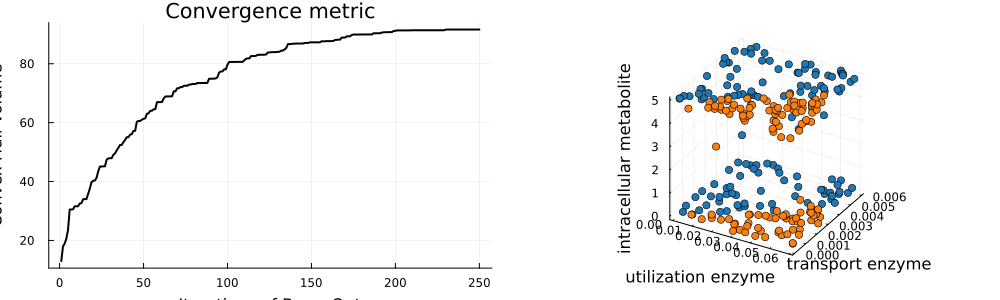

Total domains of attraction found: 2
Locations of stable steady states: Any[[0.12205490292151133, 0.0025303273494707225, 0.004998315147305014], [78.31657395784278, 0.047338512265135156, 0.0025089715408258277]]


In [79]:
using Plots
using DataFrames
using StatsPlots # For scatter plot with groups

not_initial = filter(row -> row[:conv] != "initial", sample_data)
initial = filter(row -> row[:conv] == "initial", sample_data)

# Assuming 'data' is a DataFrame in Julia with columns :class and :score
classes = unique(sample_data[!, :class])
scores = not_initial[!, :conv]

println("Total domains of attraction found: ", length(steady_states))
println("Locations of stable steady states: ", steady_states)

# Convergence metric
p1 = plot(scores, ylabel="Convex Hull Volume", xlabel="Iterations of BayesOpt", legend=false, color=:black, lw=2, title="Convergence metric")
ylabel!(p1, "Convex Hull Volume", fontsize=15)
xlabel!(p1, "Iterations of BayesOpt", fontsize=15)

# Initial samples
plot_data = filter(row -> row[:class] == classes[1], sample_data)
plot_data2 = filter(row -> row[:class] == classes[2], sample_data)

p2 = scatter3d([plot_data.y, plot_data2.y],[plot_data.z, plot_data2.z],[plot_data.x, plot_data2.x], 
            xlabel="utilization enzyme", 
            ylabel="transport enzyme", 
            zlabel="intracellular metabolite",
            legend=false,  # Set legend to true to see the class labels
            color=[palette(:tab10)[1] palette(:tab10)[2]]) 


# Combine plots
final_plot = plot(p1, p2, layout=(1,2), size=(1000,300))

# Display the plot
display(final_plot)

In [80]:
savefig(final_plot, "test_run.png")

"/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/sampling-networks/hiscock_model/3d/test_run.png"